## Initialisation time series

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


In [43]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [45]:
dataframe = read_csv('Z1_RYG_20190423_cost.csv', usecols=[0,4], engine='python')
#dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [46]:
dataset = dataframe.values

In [48]:
#dataset = dataset.astype('float32')
#where_are_NaNs = np.isnan(dataset)
#dataset[where_are_NaNs] = 0

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [49]:
newdataset1 = []
newdataset2 = []
for i in range(len(dataset)):
    a = i
    b = dataset[i, 1]
    newdataset1.append(a)
    newdataset2.append(b)

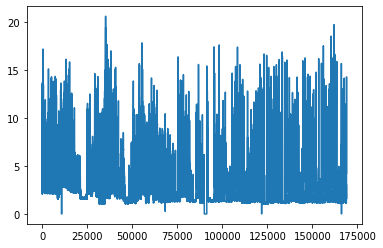

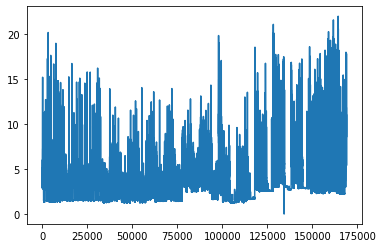

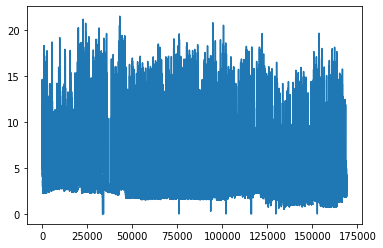

In [83]:
raw_values = np.asarray(newdataset2)
l=len(raw_values)
#plt.plot(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):int(-l/3)])
plt.show()
plt.plot(raw_values[int(-l/3):])
plt.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

[-11.3272 -11.3272]
[11.03015 11.03015]


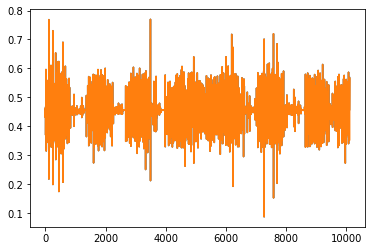

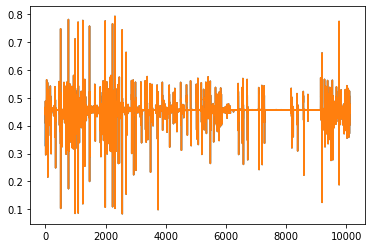

In [54]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(7*l/351)])
plt.show()
plt.plot(test_scaled[:int(7*l/351)])
plt.show()

## Entrainement

In [91]:
lstm_model = fit_lstm(train_scaled, 1, 1, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(337959, 1, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


array([[0.45610416],
       [0.45616642],
       [0.45598716],
       ...,
       [0.45650637],
       [0.45648637],
       [0.45657665]], dtype=float32)

## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [92]:
# walk-forward validation on the test data
predictions = list()
for i in range(int(len(test_scaled)/100)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]
	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, yhat, expected))
    

	predictions.append(yhat)

#for i in range(len(test_scaled)):
#	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

hour=0, Predicted=10.925259, Expected=10.893400
hour=0, Predicted=10.895611, Expected=11.016917
hour=0, Predicted=11.021569, Expected=10.589017
hour=0, Predicted=10.586710, Expected=10.840800
hour=0, Predicted=10.847040, Expected=10.799233
hour=1, Predicted=10.801824, Expected=10.978500
hour=1, Predicted=10.983844, Expected=11.775050
hour=1, Predicted=11.787906, Expected=11.336183
hour=1, Predicted=11.333736, Expected=10.146233
hour=1, Predicted=10.133960, Expected=10.405817
hour=1, Predicted=10.412153, Expected=10.424750
hour=2, Predicted=10.428098, Expected=10.429300
hour=2, Predicted=10.432468, Expected=9.611950
hour=2, Predicted=9.604601, Expected=5.614867
hour=2, Predicted=5.562416, Expected=5.664383
hour=2, Predicted=5.668114, Expected=5.629300
hour=2, Predicted=5.631972, Expected=5.606800
hour=3, Predicted=5.609630, Expected=5.589517
hour=3, Predicted=5.592412, Expected=5.623500
hour=3, Predicted=5.627036, Expected=5.634517
hour=3, Predicted=5.637767, Expected=5.650267
hour=3, P

hour=30, Predicted=9.353619, Expected=10.054283
hour=30, Predicted=10.065998, Expected=10.221917
hour=30, Predicted=10.227116, Expected=10.202350
hour=30, Predicted=10.205217, Expected=11.016967
hour=30, Predicted=11.030039, Expected=11.371100
hour=31, Predicted=11.378599, Expected=9.928967
hour=31, Predicted=9.913306, Expected=9.318467
hour=31, Predicted=9.313809, Expected=9.147733
hour=31, Predicted=9.148699, Expected=9.422533
hour=31, Predicted=9.429057, Expected=8.928850
hour=31, Predicted=8.925699, Expected=8.768583
hour=32, Predicted=8.769681, Expected=8.726900
hour=32, Predicted=8.729490, Expected=8.739700
hour=32, Predicted=8.742972, Expected=4.842033
hour=32, Predicted=4.791097, Expected=3.487967
hour=32, Predicted=3.473494, Expected=3.430900
hour=32, Predicted=3.433296, Expected=3.430933
hour=33, Predicted=3.434046, Expected=3.421933
hour=33, Predicted=3.424932, Expected=3.434100
hour=33, Predicted=3.437364, Expected=3.414983
hour=33, Predicted=3.417856, Expected=3.430567
hou

hour=59, Predicted=2.264590, Expected=2.255850
hour=59, Predicted=2.258892, Expected=2.252350
hour=59, Predicted=2.255418, Expected=2.252550
hour=60, Predicted=2.255664, Expected=2.249383
hour=60, Predicted=2.252456, Expected=2.258583
hour=60, Predicted=2.261810, Expected=2.252400
hour=60, Predicted=2.255434, Expected=2.250350
hour=60, Predicted=2.253436, Expected=2.251067
hour=60, Predicted=2.254188, Expected=2.250017
hour=61, Predicted=2.253116, Expected=2.256833
hour=61, Predicted=2.260031, Expected=2.256017
hour=61, Predicted=2.259119, Expected=2.248333
hour=61, Predicted=2.251349, Expected=2.248267
hour=61, Predicted=2.251378, Expected=2.247633
hour=61, Predicted=2.250737, Expected=2.251267
hour=62, Predicted=2.254424, Expected=2.258700
hour=62, Predicted=2.261905, Expected=2.309783
hour=62, Predicted=2.313533, Expected=2.311483
hour=62, Predicted=2.314616, Expected=2.314200
hour=62, Predicted=2.317346, Expected=2.312700
hour=62, Predicted=2.315793, Expected=2.307533
hour=63, Pred

hour=88, Predicted=8.437920, Expected=8.422850
hour=88, Predicted=8.425810, Expected=8.287650
hour=88, Predicted=8.289064, Expected=8.001000
hour=89, Predicted=8.000496, Expected=7.997367
hour=89, Predicted=8.000433, Expected=7.769867
hour=89, Predicted=7.770114, Expected=7.289617
hour=89, Predicted=7.286638, Expected=7.298617
hour=89, Predicted=7.301841, Expected=7.263800
hour=89, Predicted=7.266476, Expected=7.274400
hour=90, Predicted=7.277645, Expected=7.261983
hour=90, Predicted=7.264940, Expected=7.224250
hour=90, Predicted=7.226889, Expected=6.803050
hour=90, Predicted=6.800830, Expected=6.653567
hour=90, Predicted=6.654800, Expected=5.554583
hour=90, Predicted=5.543521, Expected=5.643367
hour=91, Predicted=5.647587, Expected=5.618100
hour=91, Predicted=5.620895, Expected=5.601300
hour=91, Predicted=5.604202, Expected=2.303267
hour=91, Predicted=2.261324, Expected=2.263033
hour=91, Predicted=2.265641, Expected=2.266300
hour=91, Predicted=2.269453, Expected=2.270217
hour=92, Pred

hour=117, Predicted=10.193653, Expected=9.480900
hour=117, Predicted=9.474868, Expected=9.676700
hour=117, Predicted=9.682249, Expected=9.641917
hour=117, Predicted=9.644593, Expected=9.379217
hour=118, Predicted=9.379017, Expected=9.164117
hour=118, Predicted=9.164521, Expected=8.842750
hour=118, Predicted=8.841804, Expected=8.946483
hour=118, Predicted=8.950890, Expected=8.951067
hour=118, Predicted=8.954236, Expected=9.002117
hour=118, Predicted=9.005866, Expected=7.963650
hour=119, Predicted=7.953390, Expected=6.422667
hour=119, Predicted=6.405666, Expected=5.160567
hour=119, Predicted=5.147329, Expected=2.246083
hour=119, Predicted=2.209766, Expected=2.248300
hour=119, Predicted=2.251440, Expected=2.250417
hour=119, Predicted=2.253555, Expected=2.247067
hour=120, Predicted=2.250137, Expected=2.247600
hour=120, Predicted=2.250719, Expected=2.244033
hour=120, Predicted=2.247100, Expected=2.245333
hour=120, Predicted=2.248462, Expected=2.253867
hour=120, Predicted=2.257085, Expected=

hour=146, Predicted=6.057994, Expected=2.717383
hour=146, Predicted=2.674825, Expected=2.257900
hour=147, Predicted=2.255189, Expected=2.259000
hour=147, Predicted=2.262126, Expected=2.268267
hour=147, Predicted=2.271494, Expected=2.337417
hour=147, Predicted=2.341392, Expected=4.443000
hour=147, Predicted=4.470899, Expected=5.400733
hour=147, Predicted=5.415507, Expected=5.781733
hour=148, Predicted=5.789561, Expected=6.691133
hour=148, Predicted=6.705334, Expected=7.348067
hour=148, Predicted=7.359247, Expected=8.331750
hour=148, Predicted=8.346830, Expected=9.216900
hour=148, Predicted=9.230812, Expected=10.367200
hour=148, Predicted=10.384240, Expected=11.350700
hour=149, Predicted=11.365778, Expected=8.316133
hour=149, Predicted=8.278065, Expected=8.416700
hour=149, Predicted=8.421067, Expected=8.653167
hour=149, Predicted=8.659217, Expected=8.609133
hour=149, Predicted=8.611694, Expected=8.937017
hour=149, Predicted=8.944193, Expected=8.907900
hour=150, Predicted=8.910647, Expect

hour=175, Predicted=13.216104, Expected=13.903283
hour=175, Predicted=13.914903, Expected=15.057833
hour=175, Predicted=15.074923, Expected=15.250250
hour=175, Predicted=15.255756, Expected=16.092000
hour=176, Predicted=16.105395, Expected=17.150333
hour=176, Predicted=17.166294, Expected=17.890383
hour=176, Predicted=17.902562, Expected=18.333783
hour=176, Predicted=18.342375, Expected=18.060050
hour=176, Predicted=18.059711, Expected=16.684417
hour=176, Predicted=16.669654, Expected=14.918200
hour=177, Predicted=14.898120, Expected=13.830300
hour=177, Predicted=13.819385, Expected=13.083267
hour=177, Predicted=13.076835, Expected=11.860350
hour=177, Predicted=11.847636, Expected=10.494050
hour=177, Predicted=10.479413, Expected=10.108317
hour=177, Predicted=10.106550, Expected=9.706733
hour=178, Predicted=9.704764, Expected=9.496033
hour=178, Predicted=9.496493, Expected=9.445917
hour=178, Predicted=9.448400, Expected=9.958967
hour=178, Predicted=9.968406, Expected=10.446467
hour=178

hour=203, Predicted=9.187268, Expected=9.210317
hour=203, Predicted=9.213724, Expected=9.104367
hour=203, Predicted=9.106149, Expected=8.487817
hour=203, Predicted=8.483081, Expected=8.633800
hour=204, Predicted=8.638731, Expected=8.781733
hour=204, Predicted=8.786688, Expected=8.831733
hour=204, Predicted=8.835470, Expected=8.969067
hour=204, Predicted=8.973891, Expected=9.009867
hour=204, Predicted=9.013488, Expected=8.946783
hour=204, Predicted=8.949104, Expected=8.965933
hour=205, Predicted=8.969285, Expected=8.932467
hour=205, Predicted=8.935159, Expected=8.922317
hour=205, Predicted=8.925302, Expected=8.946217
hour=205, Predicted=8.949627, Expected=8.980067
hour=205, Predicted=8.983602, Expected=8.980833
hour=205, Predicted=8.983955, Expected=9.159967
hour=206, Predicted=9.165309, Expected=9.249217
hour=206, Predicted=9.253442, Expected=8.954017
hour=206, Predicted=8.953404, Expected=8.761350
hour=206, Predicted=8.762038, Expected=8.685583
hour=206, Predicted=8.687745, Expected=8

hour=232, Predicted=9.419687, Expected=9.426800
hour=232, Predicted=9.430047, Expected=9.433067
hour=232, Predicted=9.436257, Expected=9.351717
hour=232, Predicted=9.353809, Expected=9.341883
hour=232, Predicted=9.344872, Expected=8.895917
hour=233, Predicted=8.893379, Expected=8.568317
hour=233, Predicted=8.567292, Expected=8.621733
hour=233, Predicted=8.625513, Expected=8.669183
hour=233, Predicted=8.672888, Expected=8.825933
hour=233, Predicted=8.830998, Expected=8.557500
hour=233, Predicted=8.557228, Expected=8.542067
hour=234, Predicted=8.544986, Expected=8.519083
hour=234, Predicted=8.521908, Expected=8.495017
hour=234, Predicted=8.497828, Expected=8.496967
hour=234, Predicted=8.500103, Expected=8.529233
hour=234, Predicted=8.532749, Expected=8.594350
hour=234, Predicted=8.598275, Expected=8.632700
hour=235, Predicted=8.636291, Expected=8.595683
hour=235, Predicted=8.598331, Expected=8.591867
hour=235, Predicted=8.594931, Expected=8.578933
hour=235, Predicted=8.581883, Expected=8

hour=261, Predicted=5.097403, Expected=5.089150
hour=261, Predicted=5.092195, Expected=5.074183
hour=261, Predicted=5.077108, Expected=5.071983
hour=261, Predicted=5.075067, Expected=5.102917
hour=261, Predicted=5.106415, Expected=5.130183
hour=262, Predicted=5.133636, Expected=5.146517
hour=262, Predicted=5.149832, Expected=5.151933
hour=262, Predicted=5.155113, Expected=5.132417
hour=262, Predicted=5.135285, Expected=5.131600
hour=262, Predicted=5.134702, Expected=5.137733
hour=262, Predicted=5.140922, Expected=5.175217
hour=263, Predicted=5.178797, Expected=5.187300
hour=263, Predicted=5.190563, Expected=5.177817
hour=263, Predicted=5.180810, Expected=5.149083
hour=263, Predicted=5.151836, Expected=5.142867
hour=263, Predicted=5.145901, Expected=5.143800
hour=263, Predicted=5.146923, Expected=5.148933
hour=264, Predicted=5.152109, Expected=5.124500
hour=264, Predicted=5.127306, Expected=5.157650
hour=264, Predicted=5.161177, Expected=5.142000
hour=264, Predicted=5.144916, Expected=5

In [93]:
predictions

[10.925259206342696,
 10.895611228001117,
 11.021568777490204,
 10.586710374543612,
 10.847040127760172,
 10.801824352544006,
 10.983843582811952,
 11.787905755883456,
 11.333736377009208,
 10.133959918629582,
 10.412153038231079,
 10.428098381626606,
 10.43246848036945,
 9.604600549668074,
 5.562416045532172,
 5.668113727172669,
 5.631972456327081,
 5.60963014755249,
 5.592411963978951,
 5.627036426562071,
 5.637766584152525,
 5.6535758109038525,
 5.6756702120149685,
 5.696100963320787,
 5.666566118103807,
 5.67604141278321,
 5.683944012429769,
 5.678715213198012,
 5.678289625280555,
 5.68062442099696,
 5.661560121619161,
 5.656547065529228,
 5.699677108048852,
 5.671992770141904,
 5.6579678677017045,
 5.618217671582102,
 5.60342268935144,
 5.612792153117602,
 5.605658188497479,
 5.656724091854151,
 5.589098967102712,
 5.6036317515313625,
 5.5496459140032535,
 5.681544291598146,
 7.022711220801418,
 9.729510683456605,
 10.389879094606098,
 11.28845843857879,
 12.432600925046746,
 13.7

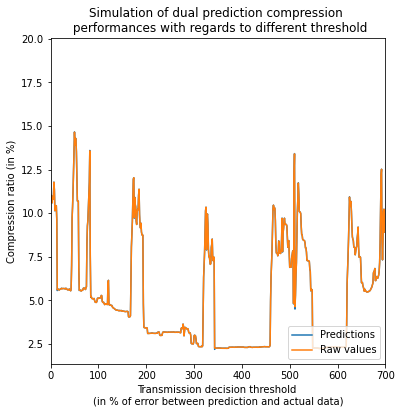

In [134]:
fig, ax = plt.subplots(figsize = (6,6))
#ax = fig.add_subplot(111, projection='3d')

ax.set_title('Simulation of dual prediction compression \n performances with regards to different threshold') 
  
# label x-axis and y-axis 
ax.set_xlabel('Transmission decision threshold \n(in % of error between prediction and actual data)') 
ax.set_ylabel('Compression ratio (in %)') 

# set x, y-axis limits  
ax.set_xlim(0, 700) 
#ax.set_ylim(0, 100) 
plt.plot(predictions, label = "Predictions")
plt.plot(raw_values[len(train):len(train) + int(len(test_scaled)/10) + 1], label = "Raw values")
ax.legend(loc='lower right')

#plt.plot(newdataset2[1791:1990], newdataset3[1791:1990], c='green')

plt.show()

In [89]:
count = 0
for i in range(len(test_scaled)):
    if (np.fabs(raw_values[len(train)+i+1] - predictions[i])<0.01):
        count +=1

print(count/i)

0.21028648530290747


In [80]:
file=open('predictions_energy.txt','w')
for items in predictions:
    file.writelines(items)
    file.writelines('\n')
file.close()

TypeError: 'numpy.float64' object is not iterable

In [65]:
np.savetxt("predictions_energy.csv", predictions, delimiter=",")

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

In [74]:
mean_absolute_percentage_error(raw_values[len(train)+1:len(train)+int(len(test_scaled)/10)+1],predictions[:int(len(test_scaled)/10)])

0.03323746652330407

Generate proper data with 1 data shift

In [96]:
# walk-forward validation on the test data
y_train = list()
X_train = list()
y_train.append(test_scaled[0, 0:-1][0])
X_train.append(0)
for i in range(1,len(test_scaled)):
	# make one-step forecast
    X_train.append(test_scaled[i-1, 0:-1][0])
    y_train.append(test_scaled[i, 0:-1][0])
    
for i in range(len(test_scaled)):
	print('X_train=%f, y_train=%f' % (X_train[i], y_train[i]))

X_train=0.000000, y_train=0.328542
X_train=0.328542, y_train=0.453087
X_train=0.453087, y_train=0.460951
X_train=0.460951, y_train=0.438754
X_train=0.438754, y_train=0.466114
X_train=0.466114, y_train=0.454306
X_train=0.454306, y_train=0.463195
X_train=0.463195, y_train=0.488044
X_train=0.488044, y_train=0.438312
X_train=0.438312, y_train=0.408077
X_train=0.408077, y_train=0.466428
X_train=0.466428, y_train=0.456741
X_train=0.456741, y_train=0.456162
X_train=0.456162, y_train=0.423076
X_train=0.423076, y_train=0.295075
X_train=0.295075, y_train=0.457972
X_train=0.457972, y_train=0.454567
X_train=0.454567, y_train=0.455073
X_train=0.455073, y_train=0.455283
X_train=0.455283, y_train=0.457347
X_train=0.457347, y_train=0.456422
X_train=0.456422, y_train=0.456613
X_train=0.456613, y_train=0.456865
X_train=0.456865, y_train=0.456802
X_train=0.456802, y_train=0.454815
X_train=0.454815, y_train=0.456341
X_train=0.456341, y_train=0.456298
X_train=0.456298, y_train=0.455775
X_train=0.455775, y_

X_train=0.455596, y_train=0.455548
X_train=0.455548, y_train=0.455872
X_train=0.455872, y_train=0.455613
X_train=0.455613, y_train=0.458628
X_train=0.458628, y_train=0.456245
X_train=0.456245, y_train=0.450277
X_train=0.450277, y_train=0.456002
X_train=0.456002, y_train=0.455910
X_train=0.455910, y_train=0.491412
X_train=0.491412, y_train=0.556261
X_train=0.556261, y_train=0.485963
X_train=0.485963, y_train=0.485957
X_train=0.485957, y_train=0.475690
X_train=0.475690, y_train=0.482845
X_train=0.482845, y_train=0.477385
X_train=0.477385, y_train=0.459179
X_train=0.459179, y_train=0.451285
X_train=0.451285, y_train=0.501134
X_train=0.501134, y_train=0.443996
X_train=0.443996, y_train=0.445975
X_train=0.445975, y_train=0.451844
X_train=0.451844, y_train=0.438747
X_train=0.438747, y_train=0.401245
X_train=0.401245, y_train=0.239572
X_train=0.239572, y_train=0.456326
X_train=0.456326, y_train=0.456259
X_train=0.456259, y_train=0.456273
X_train=0.456273, y_train=0.454643
X_train=0.454643, y_

X_train=0.455818, y_train=0.456198
X_train=0.456198, y_train=0.456177
X_train=0.456177, y_train=0.456043
X_train=0.456043, y_train=0.455840
X_train=0.455840, y_train=0.455719
X_train=0.455719, y_train=0.455944
X_train=0.455944, y_train=0.455900
X_train=0.455900, y_train=0.455793
X_train=0.455793, y_train=0.455811
X_train=0.455811, y_train=0.456912
X_train=0.456912, y_train=0.456719
X_train=0.456719, y_train=0.455790
X_train=0.455790, y_train=0.456229
X_train=0.456229, y_train=0.455446
X_train=0.455446, y_train=0.455509
X_train=0.455509, y_train=0.455925
X_train=0.455925, y_train=0.455560
X_train=0.455560, y_train=0.455825
X_train=0.455825, y_train=0.455959
X_train=0.455959, y_train=0.455904
X_train=0.455904, y_train=0.455780
X_train=0.455780, y_train=0.456130
X_train=0.456130, y_train=0.456075
X_train=0.456075, y_train=0.456157
X_train=0.456157, y_train=0.456207
X_train=0.456207, y_train=0.456349
X_train=0.456349, y_train=0.455831
X_train=0.455831, y_train=0.456052
X_train=0.456052, y_

X_train=0.451229, y_train=0.445801
X_train=0.445801, y_train=0.452338
X_train=0.452338, y_train=0.454345
X_train=0.454345, y_train=0.455525
X_train=0.455525, y_train=0.459469
X_train=0.459469, y_train=0.436515
X_train=0.436515, y_train=0.382156
X_train=0.382156, y_train=0.467757
X_train=0.467757, y_train=0.456967
X_train=0.456967, y_train=0.455873
X_train=0.455873, y_train=0.455745
X_train=0.455745, y_train=0.455782
X_train=0.455782, y_train=0.456651
X_train=0.456651, y_train=0.460315
X_train=0.460315, y_train=0.464398
X_train=0.464398, y_train=0.458337
X_train=0.458337, y_train=0.464608
X_train=0.464608, y_train=0.456889
X_train=0.456889, y_train=0.457291
X_train=0.457291, y_train=0.454437
X_train=0.454437, y_train=0.453872
X_train=0.453872, y_train=0.455421
X_train=0.455421, y_train=0.455661
X_train=0.455661, y_train=0.456056
X_train=0.456056, y_train=0.455173
X_train=0.455173, y_train=0.453556
X_train=0.453556, y_train=0.454922
X_train=0.454922, y_train=0.458403
X_train=0.458403, y_

X_train=0.455734, y_train=0.455767
X_train=0.455767, y_train=0.455686
X_train=0.455686, y_train=0.456041
X_train=0.456041, y_train=0.456468
X_train=0.456468, y_train=0.455992
X_train=0.455992, y_train=0.455961
X_train=0.455961, y_train=0.455784
X_train=0.455784, y_train=0.455896
X_train=0.455896, y_train=0.455523
X_train=0.455523, y_train=0.456082
X_train=0.456082, y_train=0.456035
X_train=0.456035, y_train=0.455621
X_train=0.455621, y_train=0.457780
X_train=0.457780, y_train=0.470877
X_train=0.470877, y_train=0.544650
X_train=0.544650, y_train=0.536250
X_train=0.536250, y_train=0.500058
X_train=0.500058, y_train=0.507362
X_train=0.507362, y_train=0.503663
X_train=0.503663, y_train=0.461040
X_train=0.461040, y_train=0.455159
X_train=0.455159, y_train=0.451585
X_train=0.451585, y_train=0.448387
X_train=0.448387, y_train=0.458278
X_train=0.458278, y_train=0.436536
X_train=0.436536, y_train=0.409553
X_train=0.409553, y_train=0.460001
X_train=0.460001, y_train=0.471338
X_train=0.471338, y_

X_train=0.455990, y_train=0.456024
X_train=0.456024, y_train=0.456074
X_train=0.456074, y_train=0.455864
X_train=0.455864, y_train=0.455868
X_train=0.455868, y_train=0.455909
X_train=0.455909, y_train=0.456104
X_train=0.456104, y_train=0.455749
X_train=0.455749, y_train=0.455541
X_train=0.455541, y_train=0.456882
X_train=0.456882, y_train=0.462191
X_train=0.462191, y_train=0.562505
X_train=0.562505, y_train=0.505732
X_train=0.505732, y_train=0.484020
X_train=0.484020, y_train=0.486592
X_train=0.486592, y_train=0.507881
X_train=0.507881, y_train=0.502602
X_train=0.502602, y_train=0.457652
X_train=0.457652, y_train=0.460120
X_train=0.460120, y_train=0.453189
X_train=0.453189, y_train=0.451296
X_train=0.451296, y_train=0.432842
X_train=0.432842, y_train=0.423390
X_train=0.423390, y_train=0.458107
X_train=0.458107, y_train=0.449068
X_train=0.449068, y_train=0.455497
X_train=0.455497, y_train=0.466669
X_train=0.466669, y_train=0.440492
X_train=0.440492, y_train=0.448018
X_train=0.448018, y_

X_train=0.457625, y_train=0.467527
X_train=0.467527, y_train=0.460475
X_train=0.460475, y_train=0.458704
X_train=0.458704, y_train=0.455587
X_train=0.455587, y_train=0.455358
X_train=0.455358, y_train=0.455255
X_train=0.455255, y_train=0.457613
X_train=0.457613, y_train=0.463713
X_train=0.463713, y_train=0.460261
X_train=0.460261, y_train=0.460226
X_train=0.460226, y_train=0.463420
X_train=0.463420, y_train=0.453966
X_train=0.453966, y_train=0.458031
X_train=0.458031, y_train=0.454618
X_train=0.454618, y_train=0.458644
X_train=0.458644, y_train=0.461515
X_train=0.461515, y_train=0.458061
X_train=0.458061, y_train=0.457857
X_train=0.457857, y_train=0.458423
X_train=0.458423, y_train=0.458866
X_train=0.458866, y_train=0.453815
X_train=0.453815, y_train=0.458203
X_train=0.458203, y_train=0.478240
X_train=0.478240, y_train=0.435289
X_train=0.435289, y_train=0.448878
X_train=0.448878, y_train=0.454746
X_train=0.454746, y_train=0.457264
X_train=0.457264, y_train=0.453353
X_train=0.453353, y_

X_train=0.456215, y_train=0.455770
X_train=0.455770, y_train=0.456083
X_train=0.456083, y_train=0.456070
X_train=0.456070, y_train=0.456198
X_train=0.456198, y_train=0.455784
X_train=0.455784, y_train=0.456188
X_train=0.456188, y_train=0.455755
X_train=0.455755, y_train=0.456080
X_train=0.456080, y_train=0.455707
X_train=0.455707, y_train=0.456054
X_train=0.456054, y_train=0.456435
X_train=0.456435, y_train=0.455731
X_train=0.455731, y_train=0.455878
X_train=0.455878, y_train=0.455701
X_train=0.455701, y_train=0.456424
X_train=0.456424, y_train=0.455984
X_train=0.455984, y_train=0.456114
X_train=0.456114, y_train=0.456043
X_train=0.456043, y_train=0.456474
X_train=0.456474, y_train=0.458059
X_train=0.458059, y_train=0.455794
X_train=0.455794, y_train=0.456061
X_train=0.456061, y_train=0.455694
X_train=0.455694, y_train=0.455796
X_train=0.455796, y_train=0.455858
X_train=0.455858, y_train=0.456159
X_train=0.456159, y_train=0.456027
X_train=0.456027, y_train=0.456445
X_train=0.456445, y_

X_train=0.515777, y_train=0.166713
X_train=0.166713, y_train=0.351781
X_train=0.351781, y_train=0.455904
X_train=0.455904, y_train=0.455945
X_train=0.455945, y_train=0.456196
X_train=0.456196, y_train=0.455873
X_train=0.455873, y_train=0.456367
X_train=0.456367, y_train=0.455943
X_train=0.455943, y_train=0.455997
X_train=0.455997, y_train=0.456070
X_train=0.456070, y_train=0.456128
X_train=0.456128, y_train=0.457870
X_train=0.457870, y_train=0.504868
X_train=0.504868, y_train=0.530613
X_train=0.530613, y_train=0.474297
X_train=0.474297, y_train=0.493742
X_train=0.493742, y_train=0.480865
X_train=0.480865, y_train=0.494499
X_train=0.494499, y_train=0.537737
X_train=0.537737, y_train=0.487149
X_train=0.487149, y_train=0.461147
X_train=0.461147, y_train=0.462733
X_train=0.462733, y_train=0.438161
X_train=0.438161, y_train=0.330738
X_train=0.330738, y_train=0.430091
X_train=0.430091, y_train=0.495245
X_train=0.495245, y_train=0.457778
X_train=0.457778, y_train=0.432582
X_train=0.432582, y_

X_train=0.456100, y_train=0.455439
X_train=0.455439, y_train=0.456369
X_train=0.456369, y_train=0.455959
X_train=0.455959, y_train=0.456184
X_train=0.456184, y_train=0.460212
X_train=0.460212, y_train=0.454807
X_train=0.454807, y_train=0.455529
X_train=0.455529, y_train=0.451500
X_train=0.451500, y_train=0.455851
X_train=0.455851, y_train=0.455722
X_train=0.455722, y_train=0.455461
X_train=0.455461, y_train=0.456198
X_train=0.456198, y_train=0.455992
X_train=0.455992, y_train=0.456376
X_train=0.456376, y_train=0.455755
X_train=0.455755, y_train=0.455680
X_train=0.455680, y_train=0.456104
X_train=0.456104, y_train=0.452348
X_train=0.452348, y_train=0.442747
X_train=0.442747, y_train=0.454245
X_train=0.454245, y_train=0.461442
X_train=0.461442, y_train=0.457178
X_train=0.457178, y_train=0.457276
X_train=0.457276, y_train=0.456712
X_train=0.456712, y_train=0.460642
X_train=0.460642, y_train=0.456262
X_train=0.456262, y_train=0.455272
X_train=0.455272, y_train=0.455491
X_train=0.455491, y_

X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_train=0.455979
X_train=0.455979, y_

X_train=0.455806, y_train=0.456147
X_train=0.456147, y_train=0.455912
X_train=0.455912, y_train=0.455978
X_train=0.455978, y_train=0.456013
X_train=0.456013, y_train=0.456269
X_train=0.456269, y_train=0.455993
X_train=0.455993, y_train=0.455554
X_train=0.455554, y_train=0.456241
X_train=0.456241, y_train=0.455992
X_train=0.455992, y_train=0.456061
X_train=0.456061, y_train=0.456018
X_train=0.456018, y_train=0.455681
X_train=0.455681, y_train=0.455973
X_train=0.455973, y_train=0.456059
X_train=0.456059, y_train=0.456167
X_train=0.456167, y_train=0.455829
X_train=0.455829, y_train=0.455933
X_train=0.455933, y_train=0.456020
X_train=0.456020, y_train=0.455735
X_train=0.455735, y_train=0.455937
X_train=0.455937, y_train=0.456133
X_train=0.456133, y_train=0.455779
X_train=0.455779, y_train=0.456141
X_train=0.456141, y_train=0.456010
X_train=0.456010, y_train=0.455921
X_train=0.455921, y_train=0.456226
X_train=0.456226, y_train=0.455693
X_train=0.455693, y_train=0.456025
X_train=0.456025, y_

X_train=0.469588, y_train=0.480406
X_train=0.480406, y_train=0.497774
X_train=0.497774, y_train=0.506121
X_train=0.506121, y_train=0.516111
X_train=0.516111, y_train=0.505754
X_train=0.505754, y_train=0.450977
X_train=0.450977, y_train=0.463497
X_train=0.463497, y_train=0.473330
X_train=0.473330, y_train=0.446259
X_train=0.446259, y_train=0.462543
X_train=0.462543, y_train=0.404272
X_train=0.404272, y_train=0.351690
X_train=0.351690, y_train=0.384365
X_train=0.384365, y_train=0.685911
X_train=0.685911, y_train=0.495832
X_train=0.495832, y_train=0.442216
X_train=0.442216, y_train=0.084325
X_train=0.084325, y_train=0.427174
X_train=0.427174, y_train=0.478872
X_train=0.478872, y_train=0.479572
X_train=0.479572, y_train=0.499854
X_train=0.499854, y_train=0.479895
X_train=0.479895, y_train=0.266762
X_train=0.266762, y_train=0.456100
X_train=0.456100, y_train=0.455988
X_train=0.455988, y_train=0.457831
X_train=0.457831, y_train=0.493654
X_train=0.493654, y_train=0.524660
X_train=0.524660, y_

X_train=0.451625, y_train=0.450791
X_train=0.450791, y_train=0.456409
X_train=0.456409, y_train=0.456225
X_train=0.456225, y_train=0.493216
X_train=0.493216, y_train=0.374505
X_train=0.374505, y_train=0.493465
X_train=0.493465, y_train=0.463341
X_train=0.463341, y_train=0.456528
X_train=0.456528, y_train=0.473022
X_train=0.473022, y_train=0.372643
X_train=0.372643, y_train=0.371407
X_train=0.371407, y_train=0.526353
X_train=0.526353, y_train=0.532505
X_train=0.532505, y_train=0.523446
X_train=0.523446, y_train=0.499153
X_train=0.499153, y_train=0.466379
X_train=0.466379, y_train=0.446324
X_train=0.446324, y_train=0.436518
X_train=0.436518, y_train=0.433322
X_train=0.433322, y_train=0.408189
X_train=0.408189, y_train=0.426947
X_train=0.426947, y_train=0.413710
X_train=0.413710, y_train=0.435877
X_train=0.435877, y_train=0.384464
X_train=0.384464, y_train=0.437409
X_train=0.437409, y_train=0.463196
X_train=0.463196, y_train=0.469335
X_train=0.469335, y_train=0.478771
X_train=0.478771, y_

X_train=0.502933, y_train=0.487497
X_train=0.487497, y_train=0.488961
X_train=0.488961, y_train=0.544499
X_train=0.544499, y_train=0.499132
X_train=0.499132, y_train=0.462057
X_train=0.462057, y_train=0.463531
X_train=0.463531, y_train=0.443237
X_train=0.443237, y_train=0.336057
X_train=0.336057, y_train=0.431111
X_train=0.431111, y_train=0.486475
X_train=0.486475, y_train=0.428934
X_train=0.428934, y_train=0.459022
X_train=0.459022, y_train=0.465283
X_train=0.465283, y_train=0.445576
X_train=0.445576, y_train=0.442875
X_train=0.442875, y_train=0.456008
X_train=0.456008, y_train=0.455682
X_train=0.455682, y_train=0.462950
X_train=0.462950, y_train=0.470491
X_train=0.470491, y_train=0.464840
X_train=0.464840, y_train=0.458238
X_train=0.458238, y_train=0.439476
X_train=0.439476, y_train=0.448465
X_train=0.448465, y_train=0.455061
X_train=0.455061, y_train=0.467669
X_train=0.467669, y_train=0.480781
X_train=0.480781, y_train=0.504833
X_train=0.504833, y_train=0.449606
X_train=0.449606, y_

X_train=0.445652, y_train=0.454222
X_train=0.454222, y_train=0.461749
X_train=0.461749, y_train=0.457825
X_train=0.457825, y_train=0.457741
X_train=0.457741, y_train=0.457491
X_train=0.457491, y_train=0.461185
X_train=0.461185, y_train=0.463623
X_train=0.463623, y_train=0.458464
X_train=0.458464, y_train=0.456897
X_train=0.456897, y_train=0.457075
X_train=0.457075, y_train=0.457272
X_train=0.457272, y_train=0.459817
X_train=0.459817, y_train=0.459213
X_train=0.459213, y_train=0.456470
X_train=0.456470, y_train=0.455406
X_train=0.455406, y_train=0.456673
X_train=0.456673, y_train=0.456810
X_train=0.456810, y_train=0.455551
X_train=0.455551, y_train=0.456697
X_train=0.456697, y_train=0.456057
X_train=0.456057, y_train=0.457111
X_train=0.457111, y_train=0.455992
X_train=0.455992, y_train=0.452719
X_train=0.452719, y_train=0.449541
X_train=0.449541, y_train=0.451641
X_train=0.451641, y_train=0.450934
X_train=0.450934, y_train=0.451356
X_train=0.451356, y_train=0.452986
X_train=0.452986, y_

X_train=0.453437, y_train=0.463012
X_train=0.463012, y_train=0.455077
X_train=0.455077, y_train=0.470153
X_train=0.470153, y_train=0.478351
X_train=0.478351, y_train=0.456310
X_train=0.456310, y_train=0.466151
X_train=0.466151, y_train=0.445068
X_train=0.445068, y_train=0.445462
X_train=0.445462, y_train=0.444833
X_train=0.444833, y_train=0.463711
X_train=0.463711, y_train=0.456018
X_train=0.456018, y_train=0.456049
X_train=0.456049, y_train=0.455307
X_train=0.455307, y_train=0.430987
X_train=0.430987, y_train=0.457935
X_train=0.457935, y_train=0.458359
X_train=0.458359, y_train=0.417837
X_train=0.417837, y_train=0.437652
X_train=0.437652, y_train=0.391175
X_train=0.391175, y_train=0.371036
X_train=0.371036, y_train=0.455898
X_train=0.455898, y_train=0.456299
X_train=0.456299, y_train=0.458190
X_train=0.458190, y_train=0.530395
X_train=0.530395, y_train=0.505054
X_train=0.505054, y_train=0.467830
X_train=0.467830, y_train=0.493949
X_train=0.493949, y_train=0.490927
X_train=0.490927, y_

X_train=0.477645, y_train=0.487058
X_train=0.487058, y_train=0.457379
X_train=0.457379, y_train=0.443764
X_train=0.443764, y_train=0.453509
X_train=0.453509, y_train=0.450652
X_train=0.450652, y_train=0.363142
X_train=0.363142, y_train=0.237866
X_train=0.237866, y_train=0.456091
X_train=0.456091, y_train=0.455933
X_train=0.455933, y_train=0.455988
X_train=0.455988, y_train=0.527133
X_train=0.527133, y_train=0.470557
X_train=0.470557, y_train=0.456173
X_train=0.456173, y_train=0.455609
X_train=0.455609, y_train=0.394529
X_train=0.394529, y_train=0.431736
X_train=0.431736, y_train=0.456045
X_train=0.456045, y_train=0.456105
X_train=0.456105, y_train=0.455901
X_train=0.455901, y_train=0.456008
X_train=0.456008, y_train=0.455944
X_train=0.455944, y_train=0.455926
X_train=0.455926, y_train=0.456077
X_train=0.456077, y_train=0.456036
X_train=0.456036, y_train=0.455965
X_train=0.455965, y_train=0.455973
X_train=0.455973, y_train=0.456810
X_train=0.456810, y_train=0.464021
X_train=0.464021, y_

X_train=0.456036, y_train=0.456088
X_train=0.456088, y_train=0.455968
X_train=0.455968, y_train=0.456015
X_train=0.456015, y_train=0.455951
X_train=0.455951, y_train=0.456046
X_train=0.456046, y_train=0.487144
X_train=0.487144, y_train=0.512135
X_train=0.512135, y_train=0.455727
X_train=0.455727, y_train=0.455920
X_train=0.455920, y_train=0.451100
X_train=0.451100, y_train=0.373533
X_train=0.373533, y_train=0.455672
X_train=0.455672, y_train=0.456001
X_train=0.456001, y_train=0.456192
X_train=0.456192, y_train=0.455858
X_train=0.455858, y_train=0.455998
X_train=0.455998, y_train=0.455989
X_train=0.455989, y_train=0.456070
X_train=0.456070, y_train=0.455886
X_train=0.455886, y_train=0.456141
X_train=0.456141, y_train=0.456065
X_train=0.456065, y_train=0.456122
X_train=0.456122, y_train=0.456042
X_train=0.456042, y_train=0.455775
X_train=0.455775, y_train=0.455945
X_train=0.455945, y_train=0.477661
X_train=0.477661, y_train=0.520907
X_train=0.520907, y_train=0.455897
X_train=0.455897, y_

X_train=0.450622, y_train=0.454192
X_train=0.454192, y_train=0.454491
X_train=0.454491, y_train=0.457618
X_train=0.457618, y_train=0.460443
X_train=0.460443, y_train=0.458589
X_train=0.458589, y_train=0.410154
X_train=0.410154, y_train=0.452685
X_train=0.452685, y_train=0.458602
X_train=0.458602, y_train=0.459448
X_train=0.459448, y_train=0.445460
X_train=0.445460, y_train=0.453519
X_train=0.453519, y_train=0.454744
X_train=0.454744, y_train=0.456586
X_train=0.456586, y_train=0.455983
X_train=0.455983, y_train=0.407701
X_train=0.407701, y_train=0.350043
X_train=0.350043, y_train=0.453752
X_train=0.453752, y_train=0.450764
X_train=0.450764, y_train=0.455965
X_train=0.455965, y_train=0.456044
X_train=0.456044, y_train=0.455968
X_train=0.455968, y_train=0.455609
X_train=0.455609, y_train=0.456094
X_train=0.456094, y_train=0.452816
X_train=0.452816, y_train=0.442771
X_train=0.442771, y_train=0.454675
X_train=0.454675, y_train=0.453347
X_train=0.453347, y_train=0.450788
X_train=0.450788, y_

X_train=0.459993, y_train=0.454378
X_train=0.454378, y_train=0.371570
X_train=0.371570, y_train=0.456118
X_train=0.456118, y_train=0.455718
X_train=0.455718, y_train=0.456279
X_train=0.456279, y_train=0.456347
X_train=0.456347, y_train=0.455872
X_train=0.455872, y_train=0.455236
X_train=0.455236, y_train=0.455429
X_train=0.455429, y_train=0.455894
X_train=0.455894, y_train=0.455476
X_train=0.455476, y_train=0.454979
X_train=0.454979, y_train=0.452461
X_train=0.452461, y_train=0.446104
X_train=0.446104, y_train=0.449541
X_train=0.449541, y_train=0.454592
X_train=0.454592, y_train=0.522923
X_train=0.522923, y_train=0.475683
X_train=0.475683, y_train=0.456521
X_train=0.456521, y_train=0.455686
X_train=0.455686, y_train=0.421522
X_train=0.421522, y_train=0.420515
X_train=0.420515, y_train=0.457378
X_train=0.457378, y_train=0.455603
X_train=0.455603, y_train=0.455601
X_train=0.455601, y_train=0.455236
X_train=0.455236, y_train=0.446780
X_train=0.446780, y_train=0.446321
X_train=0.446321, y_

X_train=0.456040, y_train=0.456047
X_train=0.456047, y_train=0.456088
X_train=0.456088, y_train=0.456043
X_train=0.456043, y_train=0.455841
X_train=0.455841, y_train=0.541573
X_train=0.541573, y_train=0.456367
X_train=0.456367, y_train=0.455244
X_train=0.455244, y_train=0.455792
X_train=0.455792, y_train=0.395353
X_train=0.395353, y_train=0.431366
X_train=0.431366, y_train=0.456067
X_train=0.456067, y_train=0.455953
X_train=0.455953, y_train=0.456026
X_train=0.456026, y_train=0.455943
X_train=0.455943, y_train=0.455994
X_train=0.455994, y_train=0.455819
X_train=0.455819, y_train=0.455815
X_train=0.455815, y_train=0.456102
X_train=0.456102, y_train=0.455938
X_train=0.455938, y_train=0.456061
X_train=0.456061, y_train=0.455986
X_train=0.455986, y_train=0.456137
X_train=0.456137, y_train=0.456137
X_train=0.456137, y_train=0.455922
X_train=0.455922, y_train=0.455780
X_train=0.455780, y_train=0.480394
X_train=0.480394, y_train=0.516895
X_train=0.516895, y_train=0.455591
X_train=0.455591, y_

X_train=0.457599, y_train=0.457667
X_train=0.457667, y_train=0.456103
X_train=0.456103, y_train=0.457001
X_train=0.457001, y_train=0.456549
X_train=0.456549, y_train=0.457713
X_train=0.457713, y_train=0.457645
X_train=0.457645, y_train=0.457317
X_train=0.457317, y_train=0.455838
X_train=0.455838, y_train=0.457986
X_train=0.457986, y_train=0.457482
X_train=0.457482, y_train=0.362730
X_train=0.362730, y_train=0.395520
X_train=0.395520, y_train=0.486131
X_train=0.486131, y_train=0.511474
X_train=0.511474, y_train=0.456049
X_train=0.456049, y_train=0.456430
X_train=0.456430, y_train=0.438550
X_train=0.438550, y_train=0.387508
X_train=0.387508, y_train=0.455956
X_train=0.455956, y_train=0.456328
X_train=0.456328, y_train=0.455823
X_train=0.455823, y_train=0.455490
X_train=0.455490, y_train=0.455831
X_train=0.455831, y_train=0.455917
X_train=0.455917, y_train=0.456019
X_train=0.456019, y_train=0.456079
X_train=0.456079, y_train=0.458622
X_train=0.458622, y_train=0.504103
X_train=0.504103, y_

X_train=0.101043, y_train=0.367136
X_train=0.367136, y_train=0.473886
X_train=0.473886, y_train=0.499846
X_train=0.499846, y_train=0.492967
X_train=0.492967, y_train=0.508899
X_train=0.508899, y_train=0.526742
X_train=0.526742, y_train=0.540159
X_train=0.540159, y_train=0.481968
X_train=0.481968, y_train=0.440057
X_train=0.440057, y_train=0.446567
X_train=0.446567, y_train=0.437643
X_train=0.437643, y_train=0.442572
X_train=0.442572, y_train=0.417867
X_train=0.417867, y_train=0.438389
X_train=0.438389, y_train=0.434518
X_train=0.434518, y_train=0.432882
X_train=0.432882, y_train=0.481136
X_train=0.481136, y_train=0.511486
X_train=0.511486, y_train=0.453066
X_train=0.453066, y_train=0.455240
X_train=0.455240, y_train=0.449447
X_train=0.449447, y_train=0.379384
X_train=0.379384, y_train=0.484650
X_train=0.484650, y_train=0.485450
X_train=0.485450, y_train=0.490126
X_train=0.490126, y_train=0.501673
X_train=0.501673, y_train=0.427656
X_train=0.427656, y_train=0.465900
X_train=0.465900, y_

X_train=0.456016, y_train=0.455944
X_train=0.455944, y_train=0.456247
X_train=0.456247, y_train=0.456006
X_train=0.456006, y_train=0.456300
X_train=0.456300, y_train=0.456010
X_train=0.456010, y_train=0.469357
X_train=0.469357, y_train=0.529344
X_train=0.529344, y_train=0.455221
X_train=0.455221, y_train=0.456224
X_train=0.456224, y_train=0.455875
X_train=0.455875, y_train=0.375112
X_train=0.375112, y_train=0.450424
X_train=0.450424, y_train=0.455976
X_train=0.455976, y_train=0.456081
X_train=0.456081, y_train=0.455702
X_train=0.455702, y_train=0.456107
X_train=0.456107, y_train=0.456021
X_train=0.456021, y_train=0.455847
X_train=0.455847, y_train=0.456008
X_train=0.456008, y_train=0.456273
X_train=0.456273, y_train=0.456130
X_train=0.456130, y_train=0.456062
X_train=0.456062, y_train=0.455658
X_train=0.455658, y_train=0.456008
X_train=0.456008, y_train=0.455928
X_train=0.455928, y_train=0.472533
X_train=0.472533, y_train=0.527870
X_train=0.527870, y_train=0.453537
X_train=0.453537, y_

X_train=0.466655, y_train=0.460337
X_train=0.460337, y_train=0.456428
X_train=0.456428, y_train=0.090128
X_train=0.090128, y_train=0.435455
X_train=0.435455, y_train=0.495457
X_train=0.495457, y_train=0.492536
X_train=0.492536, y_train=0.485065
X_train=0.485065, y_train=0.504097
X_train=0.504097, y_train=0.532901
X_train=0.532901, y_train=0.534383
X_train=0.534383, y_train=0.499774
X_train=0.499774, y_train=0.435453
X_train=0.435453, y_train=0.436850
X_train=0.436850, y_train=0.422657
X_train=0.422657, y_train=0.379489
X_train=0.379489, y_train=0.330805
X_train=0.330805, y_train=0.499126
X_train=0.499126, y_train=0.498017
X_train=0.498017, y_train=0.471554
X_train=0.471554, y_train=0.454730
X_train=0.454730, y_train=0.453701
X_train=0.453701, y_train=0.462334
X_train=0.462334, y_train=0.467456
X_train=0.467456, y_train=0.458751
X_train=0.458751, y_train=0.452175
X_train=0.452175, y_train=0.448398
X_train=0.448398, y_train=0.454204
X_train=0.454204, y_train=0.500945
X_train=0.500945, y_

X_train=0.489376, y_train=0.484745
X_train=0.484745, y_train=0.406177
X_train=0.406177, y_train=0.424061
X_train=0.424061, y_train=0.457726
X_train=0.457726, y_train=0.460375
X_train=0.460375, y_train=0.552269
X_train=0.552269, y_train=0.474236
X_train=0.474236, y_train=0.393937
X_train=0.393937, y_train=0.401799
X_train=0.401799, y_train=0.430568
X_train=0.430568, y_train=0.414911
X_train=0.414911, y_train=0.343926
X_train=0.343926, y_train=0.406429
X_train=0.406429, y_train=0.455974
X_train=0.455974, y_train=0.351313
X_train=0.351313, y_train=0.459170
X_train=0.459170, y_train=0.450398
X_train=0.450398, y_train=0.452997
X_train=0.452997, y_train=0.446245
X_train=0.446245, y_train=0.636991
X_train=0.636991, y_train=0.751780
X_train=0.751780, y_train=0.479045
X_train=0.479045, y_train=0.400621
X_train=0.400621, y_train=0.496315
X_train=0.496315, y_train=0.390882
X_train=0.390882, y_train=0.052200
X_train=0.052200, y_train=0.348410
X_train=0.348410, y_train=0.455016
X_train=0.455016, y_

X_train=0.485402, y_train=0.469089
X_train=0.469089, y_train=0.469734
X_train=0.469734, y_train=0.463633
X_train=0.463633, y_train=0.458302
X_train=0.458302, y_train=0.450391
X_train=0.450391, y_train=0.418399
X_train=0.418399, y_train=0.370661
X_train=0.370661, y_train=0.311484
X_train=0.311484, y_train=0.456028
X_train=0.456028, y_train=0.455942
X_train=0.455942, y_train=0.455753
X_train=0.455753, y_train=0.456483
X_train=0.456483, y_train=0.456088
X_train=0.456088, y_train=0.455934
X_train=0.455934, y_train=0.455648
X_train=0.455648, y_train=0.455470
X_train=0.455470, y_train=0.455672
X_train=0.455672, y_train=0.456060
X_train=0.456060, y_train=0.455929
X_train=0.455929, y_train=0.456324
X_train=0.456324, y_train=0.455971
X_train=0.455971, y_train=0.455886
X_train=0.455886, y_train=0.455779
X_train=0.455779, y_train=0.456007
X_train=0.456007, y_train=0.455841
X_train=0.455841, y_train=0.456010
X_train=0.456010, y_train=0.455660
X_train=0.455660, y_train=0.456237
X_train=0.456237, y_

X_train=0.461851, y_train=0.457325
X_train=0.457325, y_train=0.458002
X_train=0.458002, y_train=0.476412
X_train=0.476412, y_train=0.513699
X_train=0.513699, y_train=0.508244
X_train=0.508244, y_train=0.483945
X_train=0.483945, y_train=0.477691
X_train=0.477691, y_train=0.212333
X_train=0.212333, y_train=0.656427
X_train=0.656427, y_train=0.595860
X_train=0.595860, y_train=0.396177
X_train=0.396177, y_train=0.483222
X_train=0.483222, y_train=0.093012
X_train=0.093012, y_train=0.449212
X_train=0.449212, y_train=0.492457
X_train=0.492457, y_train=0.505476
X_train=0.505476, y_train=0.490443
X_train=0.490443, y_train=0.501683
X_train=0.501683, y_train=0.525482
X_train=0.525482, y_train=0.483732
X_train=0.483732, y_train=0.427846
X_train=0.427846, y_train=0.434284
X_train=0.434284, y_train=0.452013
X_train=0.452013, y_train=0.456102
X_train=0.456102, y_train=0.436673
X_train=0.436673, y_train=0.410530
X_train=0.410530, y_train=0.458027
X_train=0.458027, y_train=0.463696
X_train=0.463696, y_

X_train=0.435769, y_train=0.414372
X_train=0.414372, y_train=0.503671
X_train=0.503671, y_train=0.409786
X_train=0.409786, y_train=0.482030
X_train=0.482030, y_train=0.453151
X_train=0.453151, y_train=0.456512
X_train=0.456512, y_train=0.389968
X_train=0.389968, y_train=0.372995
X_train=0.372995, y_train=0.498735
X_train=0.498735, y_train=0.507416
X_train=0.507416, y_train=0.473669
X_train=0.473669, y_train=0.471335
X_train=0.471335, y_train=0.449780
X_train=0.449780, y_train=0.444683
X_train=0.444683, y_train=0.445566
X_train=0.445566, y_train=0.445889
X_train=0.445889, y_train=0.473644
X_train=0.473644, y_train=0.510550
X_train=0.510550, y_train=0.450117
X_train=0.450117, y_train=0.455689
X_train=0.455689, y_train=0.454104
X_train=0.454104, y_train=0.361236
X_train=0.361236, y_train=0.398466
X_train=0.398466, y_train=0.443105
X_train=0.443105, y_train=0.457983
X_train=0.457983, y_train=0.462693
X_train=0.462693, y_train=0.474196
X_train=0.474196, y_train=0.465336
X_train=0.465336, y_

X_train=0.455907, y_train=0.534493
X_train=0.534493, y_train=0.462596
X_train=0.462596, y_train=0.456520
X_train=0.456520, y_train=0.455666
X_train=0.455666, y_train=0.392801
X_train=0.392801, y_train=0.434413
X_train=0.434413, y_train=0.456057
X_train=0.456057, y_train=0.455929
X_train=0.455929, y_train=0.456013
X_train=0.456013, y_train=0.455966
X_train=0.455966, y_train=0.456052
X_train=0.456052, y_train=0.456045
X_train=0.456045, y_train=0.455745
X_train=0.455745, y_train=0.455308
X_train=0.455308, y_train=0.455969
X_train=0.455969, y_train=0.455840
X_train=0.455840, y_train=0.455994
X_train=0.455994, y_train=0.456117
X_train=0.456117, y_train=0.455798
X_train=0.455798, y_train=0.456232
X_train=0.456232, y_train=0.517319
X_train=0.517319, y_train=0.480538
X_train=0.480538, y_train=0.455644
X_train=0.455644, y_train=0.455958
X_train=0.455958, y_train=0.412888
X_train=0.412888, y_train=0.413537
X_train=0.413537, y_train=0.456184
X_train=0.456184, y_train=0.456006
X_train=0.456006, y_

X_train=0.448491, y_train=0.455649
X_train=0.455649, y_train=0.456958
X_train=0.456958, y_train=0.451782
X_train=0.451782, y_train=0.472085
X_train=0.472085, y_train=0.472665
X_train=0.472665, y_train=0.457281
X_train=0.457281, y_train=0.480469
X_train=0.480469, y_train=0.465176
X_train=0.465176, y_train=0.461111
X_train=0.461111, y_train=0.455461
X_train=0.455461, y_train=0.451185
X_train=0.451185, y_train=0.439826
X_train=0.439826, y_train=0.472433
X_train=0.472433, y_train=0.436964
X_train=0.436964, y_train=0.458294
X_train=0.458294, y_train=0.458229
X_train=0.458229, y_train=0.455425
X_train=0.455425, y_train=0.435957
X_train=0.435957, y_train=0.435530
X_train=0.435530, y_train=0.454596
X_train=0.454596, y_train=0.456040
X_train=0.456040, y_train=0.457067
X_train=0.457067, y_train=0.460803
X_train=0.460803, y_train=0.490254
X_train=0.490254, y_train=0.365064
X_train=0.365064, y_train=0.693934
X_train=0.693934, y_train=0.556530
X_train=0.556530, y_train=0.468269
X_train=0.468269, y_

X_train=0.462217, y_train=0.460114
X_train=0.460114, y_train=0.457967
X_train=0.457967, y_train=0.452580
X_train=0.452580, y_train=0.454131
X_train=0.454131, y_train=0.456429
X_train=0.456429, y_train=0.455005
X_train=0.455005, y_train=0.461009
X_train=0.461009, y_train=0.456004
X_train=0.456004, y_train=0.464878
X_train=0.464878, y_train=0.462414
X_train=0.462414, y_train=0.460707
X_train=0.460707, y_train=0.446059
X_train=0.446059, y_train=0.460669
X_train=0.460669, y_train=0.451085
X_train=0.451085, y_train=0.463746
X_train=0.463746, y_train=0.456710
X_train=0.456710, y_train=0.465770
X_train=0.465770, y_train=0.468687
X_train=0.468687, y_train=0.452188
X_train=0.452188, y_train=0.449795
X_train=0.449795, y_train=0.454047
X_train=0.454047, y_train=0.259336
X_train=0.259336, y_train=0.452227
X_train=0.452227, y_train=0.459274
X_train=0.459274, y_train=0.452469
X_train=0.452469, y_train=0.460198
X_train=0.460198, y_train=0.451045
X_train=0.451045, y_train=0.461102
X_train=0.461102, y_

X_train=0.455000, y_train=0.432507
X_train=0.432507, y_train=0.449598
X_train=0.449598, y_train=0.459122
X_train=0.459122, y_train=0.457435
X_train=0.457435, y_train=0.457676
X_train=0.457676, y_train=0.463591
X_train=0.463591, y_train=0.456979
X_train=0.456979, y_train=0.454336
X_train=0.454336, y_train=0.455808
X_train=0.455808, y_train=0.450192
X_train=0.450192, y_train=0.464626
X_train=0.464626, y_train=0.484048
X_train=0.484048, y_train=0.491994
X_train=0.491994, y_train=0.506835
X_train=0.506835, y_train=0.537717
X_train=0.537717, y_train=0.475776
X_train=0.475776, y_train=0.295728
X_train=0.295728, y_train=0.397372
X_train=0.397372, y_train=0.481783
X_train=0.481783, y_train=0.514623
X_train=0.514623, y_train=0.458337
X_train=0.458337, y_train=0.470814
X_train=0.470814, y_train=0.473428
X_train=0.473428, y_train=0.476086
X_train=0.476086, y_train=0.460137
X_train=0.460137, y_train=0.459299
X_train=0.459299, y_train=0.254025
X_train=0.254025, y_train=0.382927
X_train=0.382927, y_

X_train=0.457737, y_train=0.444244
X_train=0.444244, y_train=0.455148
X_train=0.455148, y_train=0.463313
X_train=0.463313, y_train=0.460416
X_train=0.460416, y_train=0.426895
X_train=0.426895, y_train=0.337101
X_train=0.337101, y_train=0.532995
X_train=0.532995, y_train=0.464821
X_train=0.464821, y_train=0.457458
X_train=0.457458, y_train=0.415628
X_train=0.415628, y_train=0.339961
X_train=0.339961, y_train=0.448725
X_train=0.448725, y_train=0.453352
X_train=0.453352, y_train=0.451431
X_train=0.451431, y_train=0.450907
X_train=0.450907, y_train=0.456701
X_train=0.456701, y_train=0.457443
X_train=0.457443, y_train=0.459003
X_train=0.459003, y_train=0.458720
X_train=0.458720, y_train=0.452061
X_train=0.452061, y_train=0.452710
X_train=0.452710, y_train=0.447731
X_train=0.447731, y_train=0.455165
X_train=0.455165, y_train=0.463694
X_train=0.463694, y_train=0.462685
X_train=0.462685, y_train=0.462564
X_train=0.462564, y_train=0.459291
X_train=0.459291, y_train=0.454116
X_train=0.454116, y_

X_train=0.426122, y_train=0.429272
X_train=0.429272, y_train=0.467077
X_train=0.467077, y_train=0.454404
X_train=0.454404, y_train=0.457603
X_train=0.457603, y_train=0.486368
X_train=0.486368, y_train=0.443889
X_train=0.443889, y_train=0.455016
X_train=0.455016, y_train=0.444532
X_train=0.444532, y_train=0.303002
X_train=0.303002, y_train=0.327802
X_train=0.327802, y_train=0.457771
X_train=0.457771, y_train=0.454488
X_train=0.454488, y_train=0.457478
X_train=0.457478, y_train=0.454329
X_train=0.454329, y_train=0.457308
X_train=0.457308, y_train=0.454635
X_train=0.454635, y_train=0.457621
X_train=0.457621, y_train=0.454299
X_train=0.454299, y_train=0.457655
X_train=0.457655, y_train=0.454569
X_train=0.454569, y_train=0.457501
X_train=0.457501, y_train=0.454516
X_train=0.454516, y_train=0.457849
X_train=0.457849, y_train=0.455255
X_train=0.455255, y_train=0.456025
X_train=0.456025, y_train=0.456644
X_train=0.456644, y_train=0.453756
X_train=0.453756, y_train=0.457043
X_train=0.457043, y_

X_train=0.331586, y_train=0.488378
X_train=0.488378, y_train=0.467030
X_train=0.467030, y_train=0.485271
X_train=0.485271, y_train=0.495300
X_train=0.495300, y_train=0.526244
X_train=0.526244, y_train=0.522931
X_train=0.522931, y_train=0.516046
X_train=0.516046, y_train=0.490839
X_train=0.490839, y_train=0.427492
X_train=0.427492, y_train=0.428245
X_train=0.428245, y_train=0.458465
X_train=0.458465, y_train=0.436504
X_train=0.436504, y_train=0.353089
X_train=0.353089, y_train=0.488960
X_train=0.488960, y_train=0.484088
X_train=0.484088, y_train=0.455042
X_train=0.455042, y_train=0.480940
X_train=0.480940, y_train=0.508264
X_train=0.508264, y_train=0.500383
X_train=0.500383, y_train=0.496470
X_train=0.496470, y_train=0.390655
X_train=0.390655, y_train=0.386750
X_train=0.386750, y_train=0.471653
X_train=0.471653, y_train=0.460416
X_train=0.460416, y_train=0.453818
X_train=0.453818, y_train=0.500144
X_train=0.500144, y_train=0.438599
X_train=0.438599, y_train=0.463965
X_train=0.463965, y_

X_train=0.455291, y_train=0.456881
X_train=0.456881, y_train=0.455588
X_train=0.455588, y_train=0.456188
X_train=0.456188, y_train=0.456565
X_train=0.456565, y_train=0.455397
X_train=0.455397, y_train=0.457507
X_train=0.457507, y_train=0.454788
X_train=0.454788, y_train=0.457439
X_train=0.457439, y_train=0.459674
X_train=0.459674, y_train=0.456936
X_train=0.456936, y_train=0.456090
X_train=0.456090, y_train=0.462205
X_train=0.462205, y_train=0.452402
X_train=0.452402, y_train=0.458118
X_train=0.458118, y_train=0.451362
X_train=0.451362, y_train=0.454555
X_train=0.454555, y_train=0.453213
X_train=0.453213, y_train=0.458028
X_train=0.458028, y_train=0.453463
X_train=0.453463, y_train=0.458021
X_train=0.458021, y_train=0.454073
X_train=0.454073, y_train=0.458177
X_train=0.458177, y_train=0.453619
X_train=0.453619, y_train=0.457743
X_train=0.457743, y_train=0.446573
X_train=0.446573, y_train=0.452012
X_train=0.452012, y_train=0.453834
X_train=0.453834, y_train=0.524610
X_train=0.524610, y_

X_train=0.493126, y_train=0.455503
X_train=0.455503, y_train=0.456461
X_train=0.456461, y_train=0.411510
X_train=0.411510, y_train=0.413308
X_train=0.413308, y_train=0.455907
X_train=0.455907, y_train=0.456436
X_train=0.456436, y_train=0.455959
X_train=0.455959, y_train=0.456171
X_train=0.456171, y_train=0.455667
X_train=0.455667, y_train=0.455837
X_train=0.455837, y_train=0.455606
X_train=0.455606, y_train=0.456373
X_train=0.456373, y_train=0.455594
X_train=0.455594, y_train=0.456406
X_train=0.456406, y_train=0.455666
X_train=0.455666, y_train=0.456373
X_train=0.456373, y_train=0.455636
X_train=0.455636, y_train=0.456285
X_train=0.456285, y_train=0.455699
X_train=0.455699, y_train=0.456249
X_train=0.456249, y_train=0.455815
X_train=0.455815, y_train=0.456315
X_train=0.456315, y_train=0.455727
X_train=0.455727, y_train=0.456030
X_train=0.456030, y_train=0.456224
X_train=0.456224, y_train=0.455693
X_train=0.455693, y_train=0.456183
X_train=0.456183, y_train=0.455957
X_train=0.455957, y_

X_train=0.451405, y_train=0.460389
X_train=0.460389, y_train=0.452065
X_train=0.452065, y_train=0.460422
X_train=0.460422, y_train=0.452186
X_train=0.452186, y_train=0.460434
X_train=0.460434, y_train=0.452486
X_train=0.452486, y_train=0.459174
X_train=0.459174, y_train=0.453837
X_train=0.453837, y_train=0.457667
X_train=0.457667, y_train=0.455543
X_train=0.455543, y_train=0.456540
X_train=0.456540, y_train=0.456375
X_train=0.456375, y_train=0.455012
X_train=0.455012, y_train=0.458218
X_train=0.458218, y_train=0.452582
X_train=0.452582, y_train=0.459619
X_train=0.459619, y_train=0.451833
X_train=0.451833, y_train=0.460722
X_train=0.460722, y_train=0.451809
X_train=0.451809, y_train=0.460971
X_train=0.460971, y_train=0.451702
X_train=0.451702, y_train=0.460061
X_train=0.460061, y_train=0.452031
X_train=0.452031, y_train=0.459678
X_train=0.459678, y_train=0.453331
X_train=0.453331, y_train=0.458579
X_train=0.458579, y_train=0.453629
X_train=0.453629, y_train=0.457783
X_train=0.457783, y_

X_train=0.470868, y_train=0.455140
X_train=0.455140, y_train=0.410913
X_train=0.410913, y_train=0.454011
X_train=0.454011, y_train=0.454404
X_train=0.454404, y_train=0.418249
X_train=0.418249, y_train=0.766238
X_train=0.766238, y_train=0.480189
X_train=0.480189, y_train=0.107722
X_train=0.107722, y_train=0.371059
X_train=0.371059, y_train=0.463839
X_train=0.463839, y_train=0.459523
X_train=0.459523, y_train=0.456029
X_train=0.456029, y_train=0.454769
X_train=0.454769, y_train=0.451785
X_train=0.451785, y_train=0.455340
X_train=0.455340, y_train=0.457947
X_train=0.457947, y_train=0.452709
X_train=0.452709, y_train=0.501005
X_train=0.501005, y_train=0.513445
X_train=0.513445, y_train=0.473946
X_train=0.473946, y_train=0.470467
X_train=0.470467, y_train=0.453464
X_train=0.453464, y_train=0.464557
X_train=0.464557, y_train=0.466014
X_train=0.466014, y_train=0.474915
X_train=0.474915, y_train=0.484588
X_train=0.484588, y_train=0.479535
X_train=0.479535, y_train=0.452426
X_train=0.452426, y_

X_train=0.455859, y_train=0.455880
X_train=0.455880, y_train=0.456122
X_train=0.456122, y_train=0.455957
X_train=0.455957, y_train=0.456027
X_train=0.456027, y_train=0.455978
X_train=0.455978, y_train=0.456023
X_train=0.456023, y_train=0.455866
X_train=0.455866, y_train=0.455961
X_train=0.455961, y_train=0.455995
X_train=0.455995, y_train=0.456041
X_train=0.456041, y_train=0.455998
X_train=0.455998, y_train=0.455989
X_train=0.455989, y_train=0.455890
X_train=0.455890, y_train=0.457706
X_train=0.457706, y_train=0.491671
X_train=0.491671, y_train=0.557223
X_train=0.557223, y_train=0.477746
X_train=0.477746, y_train=0.480794
X_train=0.480794, y_train=0.478619
X_train=0.478619, y_train=0.483206
X_train=0.483206, y_train=0.480001
X_train=0.480001, y_train=0.453283
X_train=0.453283, y_train=0.470570
X_train=0.470570, y_train=0.503055
X_train=0.503055, y_train=0.435653
X_train=0.435653, y_train=0.443998
X_train=0.443998, y_train=0.456724
X_train=0.456724, y_train=0.457232
X_train=0.457232, y_

X_train=0.419122, y_train=0.446875
X_train=0.446875, y_train=0.457138
X_train=0.457138, y_train=0.452926
X_train=0.452926, y_train=0.455817
X_train=0.455817, y_train=0.455545
X_train=0.455545, y_train=0.456616
X_train=0.456616, y_train=0.456591
X_train=0.456591, y_train=0.454060
X_train=0.454060, y_train=0.449562
X_train=0.449562, y_train=0.452124
X_train=0.452124, y_train=0.455928
X_train=0.455928, y_train=0.470557
X_train=0.470557, y_train=0.460864
X_train=0.460864, y_train=0.444312
X_train=0.444312, y_train=0.461911
X_train=0.461911, y_train=0.458881
X_train=0.458881, y_train=0.453732
X_train=0.453732, y_train=0.445246
X_train=0.445246, y_train=0.455206
X_train=0.455206, y_train=0.469203
X_train=0.469203, y_train=0.459768
X_train=0.459768, y_train=0.459132
X_train=0.459132, y_train=0.459156
X_train=0.459156, y_train=0.457653
X_train=0.457653, y_train=0.462031
X_train=0.462031, y_train=0.455362
X_train=0.455362, y_train=0.456367
X_train=0.456367, y_train=0.455857
X_train=0.455857, y_

X_train=0.452696, y_train=0.458482
X_train=0.458482, y_train=0.454312
X_train=0.454312, y_train=0.458728
X_train=0.458728, y_train=0.504196
X_train=0.504196, y_train=0.512664
X_train=0.512664, y_train=0.474371
X_train=0.474371, y_train=0.463051
X_train=0.463051, y_train=0.466741
X_train=0.466741, y_train=0.459600
X_train=0.459600, y_train=0.465203
X_train=0.465203, y_train=0.453204
X_train=0.453204, y_train=0.461215
X_train=0.461215, y_train=0.452968
X_train=0.452968, y_train=0.460899
X_train=0.460899, y_train=0.455501
X_train=0.455501, y_train=0.462961
X_train=0.462961, y_train=0.449772
X_train=0.449772, y_train=0.464159
X_train=0.464159, y_train=0.463381
X_train=0.463381, y_train=0.466101
X_train=0.466101, y_train=0.466916
X_train=0.466916, y_train=0.453859
X_train=0.453859, y_train=0.450384
X_train=0.450384, y_train=0.452667
X_train=0.452667, y_train=0.461985
X_train=0.461985, y_train=0.458979
X_train=0.458979, y_train=0.466348
X_train=0.466348, y_train=0.459951
X_train=0.459951, y_

X_train=0.455988, y_train=0.455984
X_train=0.455984, y_train=0.455922
X_train=0.455922, y_train=0.455967
X_train=0.455967, y_train=0.455843
X_train=0.455843, y_train=0.456051
X_train=0.456051, y_train=0.455962
X_train=0.455962, y_train=0.456075
X_train=0.456075, y_train=0.455928
X_train=0.455928, y_train=0.456071
X_train=0.456071, y_train=0.455727
X_train=0.455727, y_train=0.456076
X_train=0.456076, y_train=0.455908
X_train=0.455908, y_train=0.456109
X_train=0.456109, y_train=0.455811
X_train=0.455811, y_train=0.456096
X_train=0.456096, y_train=0.455927
X_train=0.455927, y_train=0.455980
X_train=0.455980, y_train=0.455951
X_train=0.455951, y_train=0.455959
X_train=0.455959, y_train=0.455917
X_train=0.455917, y_train=0.456029
X_train=0.456029, y_train=0.456045
X_train=0.456045, y_train=0.455986
X_train=0.455986, y_train=0.455988
X_train=0.455988, y_train=0.455945
X_train=0.455945, y_train=0.455848
X_train=0.455848, y_train=0.456016
X_train=0.456016, y_train=0.456029
X_train=0.456029, y_

X_train=0.463819, y_train=0.574410
X_train=0.574410, y_train=0.480968
X_train=0.480968, y_train=0.482181
X_train=0.482181, y_train=0.480113
X_train=0.480113, y_train=0.482062
X_train=0.482062, y_train=0.490068
X_train=0.490068, y_train=0.494016
X_train=0.494016, y_train=0.469840
X_train=0.469840, y_train=0.468698
X_train=0.468698, y_train=0.432693
X_train=0.432693, y_train=0.397838
X_train=0.397838, y_train=0.387261
X_train=0.387261, y_train=0.449613
X_train=0.449613, y_train=0.449335
X_train=0.449335, y_train=0.450033
X_train=0.450033, y_train=0.456153
X_train=0.456153, y_train=0.454051
X_train=0.454051, y_train=0.453201
X_train=0.453201, y_train=0.452359
X_train=0.452359, y_train=0.454359
X_train=0.454359, y_train=0.455203
X_train=0.455203, y_train=0.455574
X_train=0.455574, y_train=0.455410
X_train=0.455410, y_train=0.455857
X_train=0.455857, y_train=0.368573
X_train=0.368573, y_train=0.396953
X_train=0.396953, y_train=0.456020
X_train=0.456020, y_train=0.455963
X_train=0.455963, y_

X_train=0.481318, y_train=0.621796
X_train=0.621796, y_train=0.430385
X_train=0.430385, y_train=0.514143
X_train=0.514143, y_train=0.514864
X_train=0.514864, y_train=0.480933
X_train=0.480933, y_train=0.429137
X_train=0.429137, y_train=0.426562
X_train=0.426562, y_train=0.525182
X_train=0.525182, y_train=0.443193
X_train=0.443193, y_train=0.244858
X_train=0.244858, y_train=0.474087
X_train=0.474087, y_train=0.531868
X_train=0.531868, y_train=0.469234
X_train=0.469234, y_train=0.433953
X_train=0.433953, y_train=0.505522
X_train=0.505522, y_train=0.513050
X_train=0.513050, y_train=0.406100
X_train=0.406100, y_train=0.494485
X_train=0.494485, y_train=0.514566
X_train=0.514566, y_train=0.422239
X_train=0.422239, y_train=0.433916
X_train=0.433916, y_train=0.473750
X_train=0.473750, y_train=0.510369
X_train=0.510369, y_train=0.347705
X_train=0.347705, y_train=0.406087
X_train=0.406087, y_train=0.358346
X_train=0.358346, y_train=0.445739
X_train=0.445739, y_train=0.444669
X_train=0.444669, y_

X_train=0.455933, y_train=0.455963
X_train=0.455963, y_train=0.455973
X_train=0.455973, y_train=0.456222
X_train=0.456222, y_train=0.562733
X_train=0.562733, y_train=0.372351
X_train=0.372351, y_train=0.432702
X_train=0.432702, y_train=0.456001
X_train=0.456001, y_train=0.455963
X_train=0.455963, y_train=0.455964
X_train=0.455964, y_train=0.455834
X_train=0.455834, y_train=0.456099
X_train=0.456099, y_train=0.511342
X_train=0.511342, y_train=0.476002
X_train=0.476002, y_train=0.380513
X_train=0.380513, y_train=0.455991
X_train=0.455991, y_train=0.456040
X_train=0.456040, y_train=0.455985
X_train=0.455985, y_train=0.455943
X_train=0.455943, y_train=0.455945
X_train=0.455945, y_train=0.456221
X_train=0.456221, y_train=0.571827
X_train=0.571827, y_train=0.354616
X_train=0.354616, y_train=0.441413
X_train=0.441413, y_train=0.455979
X_train=0.455979, y_train=0.456159
X_train=0.456159, y_train=0.458571
X_train=0.458571, y_train=0.515426
X_train=0.515426, y_train=0.549610
X_train=0.549610, y_

X_train=0.476690, y_train=0.483095
X_train=0.483095, y_train=0.447800
X_train=0.447800, y_train=0.446710
X_train=0.446710, y_train=0.529426
X_train=0.529426, y_train=0.414801
X_train=0.414801, y_train=0.413465
X_train=0.413465, y_train=0.483994
X_train=0.483994, y_train=0.458633
X_train=0.458633, y_train=0.465013
X_train=0.465013, y_train=0.532633
X_train=0.532633, y_train=0.540542
X_train=0.540542, y_train=0.466844
X_train=0.466844, y_train=0.341580
X_train=0.341580, y_train=0.447472
X_train=0.447472, y_train=0.431330
X_train=0.431330, y_train=0.475810
X_train=0.475810, y_train=0.278082
X_train=0.278082, y_train=0.369009
X_train=0.369009, y_train=0.407567
X_train=0.407567, y_train=0.455497
X_train=0.455497, y_train=0.456567
X_train=0.456567, y_train=0.458557
X_train=0.458557, y_train=0.572082
X_train=0.572082, y_train=0.516648
X_train=0.516648, y_train=0.407194
X_train=0.407194, y_train=0.475807
X_train=0.475807, y_train=0.470389
X_train=0.470389, y_train=0.468926
X_train=0.468926, y_

X_train=0.557668, y_train=0.442893
X_train=0.442893, y_train=0.382374
X_train=0.382374, y_train=0.440685
X_train=0.440685, y_train=0.441923
X_train=0.441923, y_train=0.452469
X_train=0.452469, y_train=0.453230
X_train=0.453230, y_train=0.454743
X_train=0.454743, y_train=0.455864
X_train=0.455864, y_train=0.456684
X_train=0.456684, y_train=0.457368
X_train=0.457368, y_train=0.522849
X_train=0.522849, y_train=0.462475
X_train=0.462475, y_train=0.390437
X_train=0.390437, y_train=0.458046
X_train=0.458046, y_train=0.463055
X_train=0.463055, y_train=0.431651
X_train=0.431651, y_train=0.447639
X_train=0.447639, y_train=0.452671
X_train=0.452671, y_train=0.310875
X_train=0.310875, y_train=0.405355
X_train=0.405355, y_train=0.456274
X_train=0.456274, y_train=0.484716
X_train=0.484716, y_train=0.531036
X_train=0.531036, y_train=0.352049
X_train=0.352049, y_train=0.455888
X_train=0.455888, y_train=0.456084
X_train=0.456084, y_train=0.456063
X_train=0.456063, y_train=0.455891
X_train=0.455891, y_

X_train=0.458953, y_train=0.456116
X_train=0.456116, y_train=0.528912
X_train=0.528912, y_train=0.455457
X_train=0.455457, y_train=0.424309
X_train=0.424309, y_train=0.462647
X_train=0.462647, y_train=0.410902
X_train=0.410902, y_train=0.501854
X_train=0.501854, y_train=0.364787
X_train=0.364787, y_train=0.435953
X_train=0.435953, y_train=0.455370
X_train=0.455370, y_train=0.421359
X_train=0.421359, y_train=0.405782
X_train=0.405782, y_train=0.332305
X_train=0.332305, y_train=0.455632
X_train=0.455632, y_train=0.456208
X_train=0.456208, y_train=0.480529
X_train=0.480529, y_train=0.537443
X_train=0.537443, y_train=0.349986
X_train=0.349986, y_train=0.455780
X_train=0.455780, y_train=0.456155
X_train=0.456155, y_train=0.511140
X_train=0.511140, y_train=0.476472
X_train=0.476472, y_train=0.380104
X_train=0.380104, y_train=0.455789
X_train=0.455789, y_train=0.456154
X_train=0.456154, y_train=0.528550
X_train=0.528550, y_train=0.441995
X_train=0.441995, y_train=0.397370
X_train=0.397370, y_

## LSTM model

Our goal is to create a LSTM model to predict y_train using the time series X_train

In [97]:
from keras import models 
from keras import layers

def define_model(len_ts,
                 hidden_neurons = 1,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
    return(model,(inp,rnn,dens))

In [98]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
hunits = 1
model1, _ = define_model(
    hidden_neurons = hunits,
    len_ts = X_train_array.shape[0])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 168980, 1)]       0         
_________________________________________________________________
RNN (LSTM)                   (None, 168980, 1)         12        
_________________________________________________________________
time_distributed (TimeDistri (None, 168980, 1)         2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [99]:
w = np.zeros(y_train_array.shape[:2])
D=1
w[D:] = 1 
w_train = w

In [100]:
from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_train_array, y_train_array, 
                   batch_size=2**9,
                   epochs=200, 
                   verbose=False,
                   sample_weight=w_train,
                   validation_split=0.05,
                   callbacks=[
                   ModelCheckpoint(filepath="weights{epoch:03d}.hdf5")])
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

Time took 2.0 min


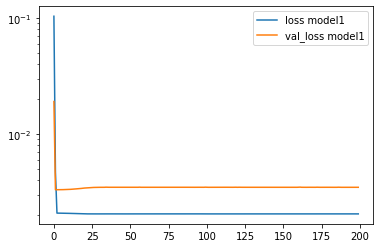

In [101]:
labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show()

In [102]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
print(warr)
print("\n")
print(uarr)
print("\n")
print(barr)

print(model1.layers[2].get_weights())
warr.shape,uarr.shape,barr.shape

[[ 0.6187129   0.35754347  0.24292392 -0.2724867 ]]


[[-0.1151216   0.35615999  0.7860531   0.49195284]]


[0.1371197  1.         0.27207637 0.19261819]
[array([[1.6718258]], dtype=float32), array([0.26913774], dtype=float32)]


((1, 4), (1, 4), (4,))

In [103]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [104]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

In [105]:
xs  = train_scaled[:,0]
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

h3=[[0.56169489]]
c3=[[1.99662936]]


In [106]:
batch_size = 1
len_ts = len(xs)
nfeature = 1

inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))

h3=[[0.56169486]]
c3=[[1.9966292]]


In [107]:
model1.layers[1].get_weights()[0]

array([[ 0.6187129 ,  0.35754347,  0.24292392, -0.2724867 ]],
      dtype=float32)

In [108]:
file_object =  open('parameters.energy.h', 'w')

In [109]:
file_object.write("//\n// Generated by spiderweak using Python.\n//\n\n#ifndef CPP_PARAMETERS_H\n#define CPP_PARAMETERS_H\n\n")

99

In [110]:
file_object.write("#define HUNIT " + str(hunits) + "\n\n")

17

In [111]:
file_object.write("#endif //CPP_PARAMETERS_H\n\nconst int hunit = HUNIT;\n\nconst float lstm_cell_input_weights[4 * HUNIT] = {")

103

In [112]:
states.layers[1].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [113]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [114]:
file_object.write("};\n\nconst float lstm_cell_hidden_weights[4 * HUNIT * HUNIT] = {")

63

In [115]:
states.layers[1].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [116]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [117]:
file_object.write("};\n\nconst float lstm_cell_bias[4 * HUNIT] = {")

45

In [118]:
states.layers[1].get_weights()[2].tofile("weights.txt", sep=", ", format="%s")

In [119]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [120]:
file_object.write("};\n\nfloat lstm_cell_hidden_layer[HUNIT] = {")

43

In [121]:
h_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [122]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [123]:
file_object.write("};\nfloat lstm_cell_cell_states[HUNIT] = {")

41

In [124]:
c_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [125]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [126]:
file_object.write("};\n\nconst float dense_weights[HUNIT] = {")

40

In [127]:
model1.layers[2].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [128]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [129]:
file_object.write("};\nconst float dense_bias = ")

28

In [130]:
model1.layers[2].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [131]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [132]:
file_object.write(";\n")

2

In [133]:
file_object.close()

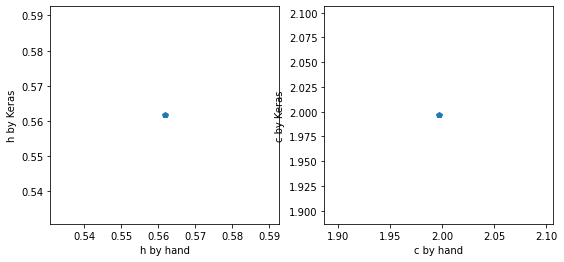

In [135]:


fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("c by hand")
ax.set_ylabel("c by Keras")
plt.show()